**Task**

Quantize the dataset after stnadradization and then do the inference. Check the output plots.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ROOT 

2023-11-30 11:31:36.628453: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 11:31:38.388291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Welcome to JupyROOT 6.28/11


In [2]:
import sys 
sys.path += ["../../../mlpf/particleflow/mlpf/"]
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

In [3]:
config, _ = parse_config("../../../mlpf/particleflow/parameters/clic.yaml") #positions on the lxplus


In [4]:
model = make_model(config, tf.float32)
model.build((1, None, config["dataset"]["num_input_features"]))

2023-11-30 11:40:27.401819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 11:40:27.443925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 11:40:27.445888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
model.summary()



Model: "pf_net_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 node_encoding (Sequential)  (1, None, 256)            70912     
                                                                 
 input_encoding_clic (Input  multiple                  0         
 EncodingCLIC)                                                   
                                                                 
 cg_id_0 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_1 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_2 (CombinedGraphLaye  multiple                  440128    
 r)                                                   

In [6]:
model.load_weights("weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)
## These files hosted at https://huggingface.co/jpata/particleflow/tree/clic_clusters_v1.6

In [7]:
## Reading the dataset
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../mlpf/tensorflow_datasets/') # Tensorflow datsets positions in the lxplus
dss = ds_builder.as_data_source("test")

In [8]:
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}

In [9]:
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)

In [10]:
data = list(tfds.as_numpy(tf_dataset))


In [12]:
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]
ycs= [d["ycand"] for d in data]

In [13]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

2023-11-30 11:42:04.400683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


In [14]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

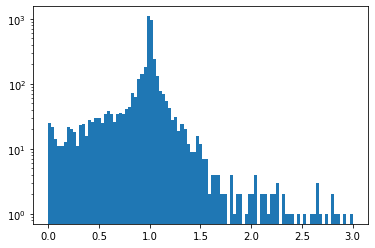

In [15]:
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.yscale("log")

In [72]:
print(ys[2].shape)
print(ycs[2].shape)

(10, 142, 8)
(10, 142, 8)


Taking out all of `pT` values 

In [16]:
true_pts_ygen = np.concatenate([d["ygen"][:, 2] for d in data])
true_pts_ycand = np.concatenate([d["ycand"][:, 2] for d in data])

In [19]:
print("True pt from ygen:", true_pts_ygen)
print("True pt from ycand:", true_pts_ycand)

True pt from ygen: [[ 1.00000000e+00 -1.00000000e+00  3.91250396e+00  8.51751029e-01
  -9.60166156e-01  2.79429704e-01  5.42142534e+00  1.00000000e+00]
 [ 1.00000000e+00 -1.00000000e+00  3.57476068e+00 -2.25394058e+00
   9.75725949e-01 -2.18995124e-01  1.72133617e+01  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.27688611e+00  2.29832387e+00
   2.75673121e-01  9.61251438e-01  6.42291737e+00  2.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  6.18536758e+00 -1.85006022e+00
   8.25993717e-01  5.63679338e-01  2.01781788e+01  2.00000000e+00]
 [ 1.00000000e+00 -1.00000000e+00  9.67933083e+00 -8.46591949e-01
  -8.92565370e-01 -4.50918049e-01  1.33609200e+01  3.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  8.60886192e+00  2.34120822e+00
  -7.80091345e-01 -6.25665665e-01  4.51536942e+01  2.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  3.38208795e+00 -4.95963007e-01
   9.03786659e-01 -4.27983284e-01  3.80920434e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  6.98776913e+00 

In [24]:
print(true_pts_ygen.shape)
print(true_pts_ycand.shape)

(100, 8)
(100, 8)


In [25]:
flat_true_pts_ygen = true_pts_ygen.flatten()
flat_true_pts_ycand = true_pts_ycand.flatten()

Warning in <TROOT::Append>: Replacing existing TH1: hist_ygen (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_ycand (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


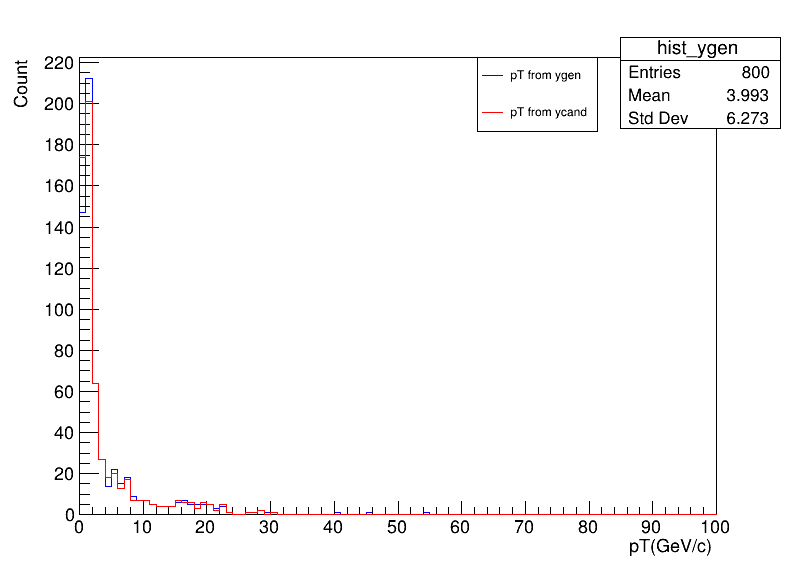

In [35]:
hist_ygen = ROOT.TH1F("hist_ygen", "True pT from ygen", 100, 0, 100)
hist_ycand = ROOT.TH1F("hist_ycand", "True pT from ycand", 100, 0, 100)


# Fill histograms with 'pt' values
for value in flat_true_pts_ygen:
    hist_ygen.Fill(value)

for value in flat_true_pts_ycand:
    hist_ycand.Fill(value)

    
canvas = ROOT.TCanvas("canvas", "True pt Comparison", 800, 600)

hist_ygen.Draw()
hist_ygen.SetTitle("")
hist_ygen.SetLineColor(ROOT.kBlue)
hist_ygen.GetXaxis().SetTitle("pT(GeV/c)")
hist_ygen.GetYaxis().SetTitle("Count")

hist_ycand.Draw("SAME")
hist_ycand.SetLineColor(ROOT.kRed)
  
legend = ROOT.TLegend(0.6, 0.77, 0.75, 0.9)
legend.AddEntry(hist_ygen, " pT from ygen", "l")
legend.AddEntry(hist_ycand, " pT from ycand", "l")
legend.Draw("SAME")

canvas.Draw()

Standardize 'pt' values


In [41]:
mean_ygen = np.mean(flat_true_pts_ygen)
std_ygen = np.std(flat_true_pts_ygen)

standardized_true_pts_ygen = (flat_true_pts_ygen - mean_ygen) / std_ygen

mean_ycand = np.mean(flat_true_pts_ycand)
std_ycand = np.std(flat_true_pts_ycand)

standardized_true_pts_ycand = (flat_true_pts_ycand - mean_ycand) / std_ycand


Warning in <TROOT::Append>: Replacing existing TH1: hist_ygen_standardized (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_ycand_standardized (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


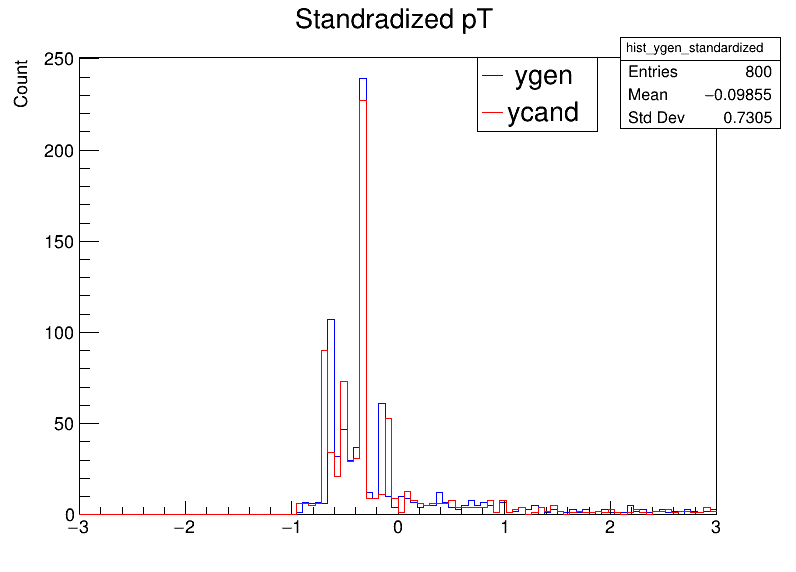

In [46]:
hist_ygen_standardized = ROOT.TH1F("hist_ygen_standardized", "Standardized True pt from ygen", 100, -3, 3)
hist_ycand_standardized = ROOT.TH1F("hist_ycand_standardized", "Standardized True pt from ycand", 100, -3, 3)

for value in standardized_true_pts_ygen:
    hist_ygen_standardized.Fill(value)

for value in standardized_true_pts_ycand:
    hist_ycand_standardized.Fill(value)
    
    
canvas = ROOT.TCanvas("canvas", "True pt Comparison", 800, 600)

hist_ygen_standardized.Draw()
hist_ygen_standardized.SetTitle("Standradized pT")
hist_ygen_standardized.SetLineColor(ROOT.kBlue)
# hist_ygen_standardized.GetXaxis().SetTitle("pT(GeV/c)")
hist_ygen_standardized.GetYaxis().SetTitle("Count")

hist_ycand_standardized.Draw("SAME")
hist_ycand_standardized.SetLineColor(ROOT.kRed)
  
legend = ROOT.TLegend(0.6, 0.77, 0.75, 0.9)
legend.AddEntry(hist_ygen, " ygen", "l")
legend.AddEntry(hist_ycand, "ycand ", "l")
legend.Draw("SAME")

canvas.Draw()

**ChatGPT** To handle outliers when standardizing the data, you can consider using more robust statistics, such as the median and interquartile range (IQR), instead of the mean and standard deviation

In [47]:
# Standardize 'pt' values with median and IQR
median_ygen = np.median(flat_true_pts_ygen)
iqr_ygen = np.percentile(flat_true_pts_ygen, 75) - np.percentile(flat_true_pts_ygen, 25)

standardized_true_pts_ygen = (flat_true_pts_ygen - median_ygen) / iqr_ygen

median_ycand = np.median(flat_true_pts_ycand)
iqr_ycand = np.percentile(flat_true_pts_ycand, 75) - np.percentile(flat_true_pts_ycand, 25)

standardized_true_pts_ycand = (flat_true_pts_ycand - median_ycand) / iqr_ycand



Warning in <TROOT::Append>: Replacing existing TH1: hist_ygen_standardized (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_ycand_standardized (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


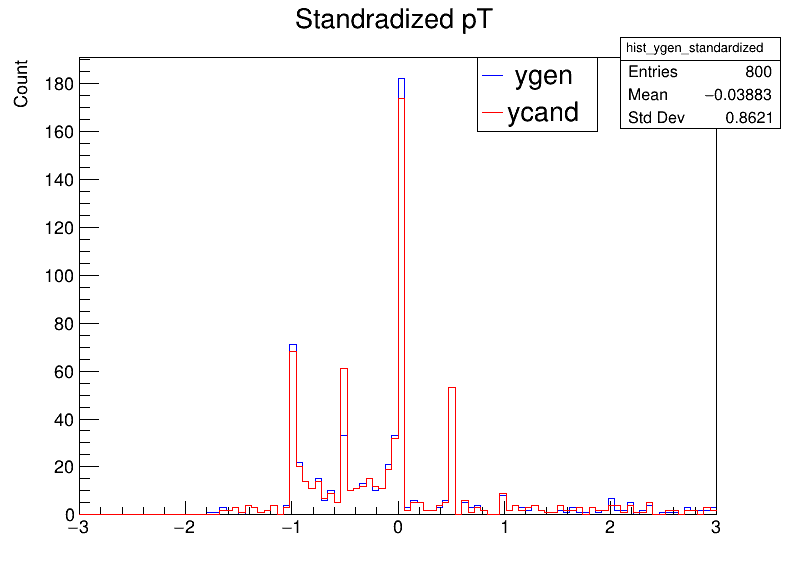

In [48]:
hist_ygen_standardized = ROOT.TH1F("hist_ygen_standardized", "Standardized True pt from ygen", 100, -3, 3)
hist_ycand_standardized = ROOT.TH1F("hist_ycand_standardized", "Standardized True pt from ycand", 100, -3, 3)

for value in standardized_true_pts_ygen:
    hist_ygen_standardized.Fill(value)

for value in standardized_true_pts_ycand:
    hist_ycand_standardized.Fill(value)
    
    
canvas = ROOT.TCanvas("canvas", "True pt Comparison", 800, 600)

hist_ygen_standardized.Draw()
hist_ygen_standardized.SetTitle("Standradized pT")
hist_ygen_standardized.SetLineColor(ROOT.kBlue)
# hist_ygen_standardized.GetXaxis().SetTitle("pT(GeV/c)")
hist_ygen_standardized.GetYaxis().SetTitle("Count")

hist_ycand_standardized.Draw("SAME")
hist_ycand_standardized.SetLineColor(ROOT.kRed)
  
legend = ROOT.TLegend(0.6, 0.77, 0.75, 0.9)
legend.AddEntry(hist_ygen, " ygen", "l")
legend.AddEntry(hist_ycand, "ycand ", "l")
legend.Draw("SAME")

canvas.Draw()

In [50]:
scale_factor_ygen = np.max(np.abs(standardized_true_pts_ygen)) / 127.0
quantized_true_pts_ygen = (standardized_true_pts_ygen / scale_factor_ygen).astype(np.int8)

scale_factor_ycand = np.max(np.abs(standardized_true_pts_ycand)) / 127.0
quantized_true_pts_ycand = (standardized_true_pts_ycand / scale_factor_ycand).astype(np.int8)


Warning in <TROOT::Append>: Replacing existing TH1: hist_ygen_quantized (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_ycand_quantized (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_quantized


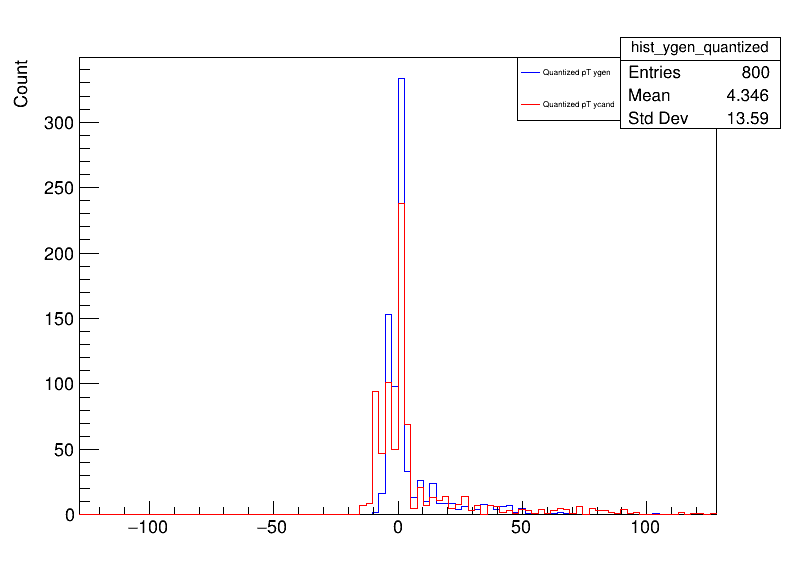

In [69]:
hist_ygen_quantized = ROOT.TH1F("hist_ygen_quantized", "", 100, -128, 128)
hist_ycand_quantized = ROOT.TH1F("hist_ycand_quantized", "Quantized Standardized True pt from ycand", 100, -128, 128)

# Fill histograms with quantized standardized 'pt' values
for value in quantized_true_pts_ygen:
    hist_ygen_quantized.Fill(value)

for value in quantized_true_pts_ycand:
    hist_ycand_quantized.Fill(value)
    
    
# Create canvas and draw histograms
canvas_quantized = ROOT.TCanvas("canvas_quantized", "Quantized Standardized True pt Comparison", 800, 600)

hist_ygen_quantized.Draw()
# hist_ygen_quantized.SetTitle("Quantized Standardized True pt Comparison")
hist_ygen_quantized.SetLineColor(ROOT.kBlue)
# hist_ygen_quantized.GetXaxis().SetTitle("Quantized pt")
hist_ygen_quantized.GetYaxis().SetTitle("Count")

hist_ycand_quantized.Draw("SAME")
hist_ycand_quantized.SetLineColor(ROOT.kRed)

# Add a legend
legend_quantized = ROOT.TLegend(0.65, 0.79, 0.78, 0.9)
legend_quantized.AddEntry(hist_ygen_quantized, "Quantized pT ygen", "l")
legend_quantized.AddEntry(hist_ycand_quantized, "Quantized pT ycand", "l")
legend_quantized.Draw("SAME")

# Show the canvas
canvas_quantized.Draw()

In [57]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

# Convert the new model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("quantized_model.tflite", "wb") as f:
    f.write(quantized_tflite_model)

2023-11-30 12:18:52.134276: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-30 12:18:52.134327: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-30 12:18:52.137764: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmp2rt9bffu
2023-11-30 12:18:52.198154: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-30 12:18:52.198243: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmp2rt9bffu
2023-11-30 12:18:52.394743: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-11-30 12:18:52.480025: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-11-30 12:18:53.485963: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmp2

In [58]:
interpreter = tf.lite.Interpreter(model_path="quantized_model.tflite")
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [59]:
# Get input and output tensors
input_tensor_index = interpreter.get_input_details()[0]['index']
output = interpreter.tensor(interpreter.get_output_details()[0]['index'])

In [61]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

In [62]:
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

In [63]:
true_pts_quantized = []
pred_pts_quantized = []


In [64]:
for ibatch in range(len(Xs)):
    # Assuming Xs is the input data for inference
    input_data = Xs[ibatch]

    mask_true_particles = ys[ibatch][..., 0] != 0
    
    true_pt_quantized = quantized_true_pts_ygen[ibatch]
    pred_pt_quantized = output_data[mask_true_particles]

    true_pts_quantized.append(true_pt_quantized)
    pred_pts_quantized.append(pred_pt_quantized)

RuntimeError: scatter_nd index out of boundsNode number 202 (SCATTER_ND) failed to invoke.

We need to quantize the Xs as well

In [66]:
quantize_input = tfmot.quantization.keras.quantize_annotate_layer

Xs_quantized = []
for ibatch in range(len(Xs)):
    # Annotate layers with quantization details
    annotated_model = quantize_input(model)
    
    # Create a concrete function for the annotated model
    concrete_func = annotated_model.prune(tf.function(lambda x: model(x)))
    
    # Quantize the input data using the concrete function
    Xs_quantized_batch = concrete_func(tf.convert_to_tensor(Xs[ibatch]))
    Xs_quantized.append(Xs_quantized_batch.numpy())

Xs_quantized = np.concatenate(Xs_quantized)

ValueError: `to_annotate` can only be a `tf.keras.layers.Layer` instance. You passed an instance of type: PFNetDense.

Let's do this again with the quatization of whole dataset and run the inference.
Quantize the dataset after standradization

In [90]:
X_0 = data[0]["X"]
ygen_0 = data[0]["ygen"]

X_1 = data[1]["X"]
ygen_1 = data[1]["ygen"]

X_2 = data[2]["X"]
ygen_2 = data[2]["ygen"]

X_3 = data[3]["X"]
ygen_3 = data[3]["ygen"]

X_4 = data[4]["X"]
ygen_4 = data[4]["ygen"]

X_5 = data[5]["X"]
ygen_5 = data[5]["ygen"]

X_6 = data[6]["X"]
ygen_6 = data[6]["ygen"]

X_7 = data[7]["X"]
ygen_7 = data[7]["ygen"]

X_8 = data[8]["X"]
ygen_8 = data[8]["ygen"]

X_9 = data[9]["X"]
ygen_9 = data[9]["ygen"]

# Concatenate all X arrays
X = np.concatenate([X_0, X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, X_9], axis=0)

# Concatenate all ygen arrays
ygen = np.concatenate([ygen_0, ygen_1, ygen_2, ygen_3, ygen_4, ygen_5, ygen_6, ygen_7, ygen_8, ygen_9], axis=0)



ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 111 and the array at index 1 has size 186

In [95]:
# Find the maximum size along the second dimension
max_size_X = max(X_0.shape[1], X_1.shape[1], X_2.shape[1], X_3.shape[1], X_4.shape[1], X_5.shape[1], X_6.shape[1], X_7.shape[1], X_8.shape[1], X_9.shape[1])

# Pad or truncate X arrays to the maximum size
X_0_padded = np.pad(X_0, ((0, 0), (0, max_size_X - X_0.shape[1]), (0, 0)), mode='constant')
X_1_padded = np.pad(X_1, ((0, 0), (0, max_size_X - X_1.shape[1]), (0, 0)), mode='constant')
X_2_padded = np.pad(X_2, ((0, 0), (0, max_size_X - X_2.shape[1]), (0, 0)), mode='constant')
X_3_padded = np.pad(X_3, ((0, 0), (0, max_size_X - X_3.shape[1]), (0, 0)), mode='constant')
X_4_padded = np.pad(X_4, ((0, 0), (0, max_size_X - X_4.shape[1]), (0, 0)), mode='constant')
X_5_padded = np.pad(X_5, ((0, 0), (0, max_size_X - X_5.shape[1]), (0, 0)), mode='constant')
X_6_padded = np.pad(X_6, ((0, 0), (0, max_size_X - X_6.shape[1]), (0, 0)), mode='constant')
X_7_padded = np.pad(X_7, ((0, 0), (0, max_size_X - X_7.shape[1]), (0, 0)), mode='constant')
X_8_padded = np.pad(X_8, ((0, 0), (0, max_size_X - X_8.shape[1]), (0, 0)), mode='constant')
X_9_padded = np.pad(X_9, ((0, 0), (0, max_size_X - X_9.shape[1]), (0, 0)), mode='constant')

# Concatenate all X arrays
X = np.concatenate([X_0_padded, X_1_padded, X_2_padded, X_3_padded, X_4_padded, X_5_padded, X_6_padded, X_7_padded, X_8_padded, X_9_padded], axis=0)


In [99]:
max_size_ygen = max(ygen_0.shape[1], ygen_1.shape[1], ygen_2.shape[1], ygen_3.shape[1], ygen_4.shape[1], ygen_5.shape[1], ygen_6.shape[1], ygen_7.shape[1], ygen_8.shape[1], ygen_9.shape[1])

# Pad or truncate ygen arrays to the maximum size
ygen_0_padded = np.pad(ygen_0, ((0, 0), (0, max_size_ygen - ygen_0.shape[1]), (0, 0)), mode='constant')
ygen_1_padded = np.pad(ygen_1, ((0, 0), (0, max_size_ygen - ygen_1.shape[1]), (0, 0)), mode='constant')
ygen_2_padded = np.pad(ygen_2, ((0, 0), (0, max_size_ygen - ygen_2.shape[1]), (0, 0)), mode='constant')
ygen_3_padded = np.pad(ygen_3, ((0, 0), (0, max_size_ygen - ygen_3.shape[1]), (0, 0)), mode='constant')
ygen_4_padded = np.pad(ygen_4, ((0, 0), (0, max_size_ygen - ygen_4.shape[1]), (0, 0)), mode='constant')
ygen_5_padded = np.pad(ygen_5, ((0, 0), (0, max_size_ygen - ygen_5.shape[1]), (0, 0)), mode='constant')
ygen_6_padded = np.pad(ygen_6, ((0, 0), (0, max_size_ygen - ygen_6.shape[1]), (0, 0)), mode='constant')
ygen_7_padded = np.pad(ygen_7, ((0, 0), (0, max_size_ygen - ygen_7.shape[1]), (0, 0)), mode='constant')
ygen_8_padded = np.pad(ygen_8, ((0, 0), (0, max_size_ygen - ygen_8.shape[1]), (0, 0)), mode='constant')
ygen_9_padded = np.pad(ygen_9, ((0, 0), (0, max_size_ygen - ygen_9.shape[1]), (0, 0)), mode='constant')

# Concatenate all ygen arrays
ygen_padded = np.concatenate([ygen_0_padded, ygen_1_padded, ygen_2_padded, ygen_3_padded, ygen_4_padded, ygen_5_padded, ygen_6_padded, ygen_7_padded, ygen_8_padded, ygen_9_padded], axis=0)


In [94]:
print(f"X_0 shape",X_0.shape)
print(f"X_1 shape",X_1.shape)
print(f"X_2 shape",X_2.shape)
print(f"X_3 shape",X_3.shape)
print(f"X_4 shape",X_4.shape)
print(f"X_5 shape",X_5.shape)
print(f"X_6 shape",X_6.shape)
print(f"X_7 shape",X_7.shape)
print(f"X_8 shape",X_8.shape)
print(f"X_9 shape",X_9.shape)


X_0 shape (10, 111, 17)
X_1 shape (10, 186, 17)
X_2 shape (10, 142, 17)
X_3 shape (10, 90, 17)
X_4 shape (10, 111, 17)
X_5 shape (10, 195, 17)
X_6 shape (10, 100, 17)
X_7 shape (10, 81, 17)
X_8 shape (10, 130, 17)
X_9 shape (10, 147, 17)


In [98]:
print(f"ygen_0 shape",ygen_0.shape)
print(f"ygen_1 shape",ygen_1.shape)
print(f"ygen_2 shape",ygen_2.shape)
print(f"ygen_3 shape",ygen_3.shape)
print(f"ygen_4 shape",ygen_4.shape)
print(f"ygen_5 shape",ygen_5.shape)
print(f"ygen_6 shape",ygen_6.shape)
print(f"ygen_7 shape",ygen_7.shape)
print(f"ygen_8 shape",ygen_8.shape)
print(f"ygen_9 shape",ygen_9.shape)



ygen_0 shape (10, 111, 8)
ygen_1 shape (10, 186, 8)
ygen_2 shape (10, 142, 8)
ygen_3 shape (10, 90, 8)
ygen_4 shape (10, 111, 8)
ygen_5 shape (10, 195, 8)
ygen_6 shape (10, 100, 8)
ygen_7 shape (10, 81, 8)
ygen_8 shape (10, 130, 8)
ygen_9 shape (10, 147, 8)


In [100]:

# Manually standardizing X
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_standardized = (X - X_mean) / X_std

# Manually standardizing ygen
ygen_mean = np.mean(ygen, axis=0)
ygen_std = np.std(ygen, axis=0)
ygen_standardized = (ygen - ygen_mean) / ygen_std

/tmp/sraj/ipykernel_3933889/955623149.py:4: RuntimeWarning: invalid value encountered in divide
  X_standardized = (X - X_mean) / X_std
/tmp/sraj/ipykernel_3933889/955623149.py:9: RuntimeWarning: invalid value encountered in divide
  ygen_standardized = (ygen - ygen_mean) / ygen_std


In [103]:
# Manually standardizing X
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_standardized = (X - X_mean) / X_std

# Manually standardizing ygen
ygen_mean = np.mean(ygen, axis=0)
ygen_std = np.std(ygen, axis=0)
ygen_standardized = (ygen - ygen_mean) / ygen_std

/tmp/sraj/ipykernel_3933889/1809141306.py:4: RuntimeWarning: invalid value encountered in divide
  X_standardized = (X - X_mean) / X_std
/tmp/sraj/ipykernel_3933889/1809141306.py:9: RuntimeWarning: invalid value encountered in divide
  ygen_standardized = (ygen - ygen_mean) / ygen_std


In [104]:

# Convert the new model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("quantized_model.tflite", "wb") as f:
    f.write(quantized_tflite_model)

# Load the quantized TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

2023-11-30 14:20:45.469489: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-30 14:20:45.469857: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-30 14:20:45.472862: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmp37ez_ma_
2023-11-30 14:20:45.534450: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-30 14:20:45.534488: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmp37ez_ma_
2023-11-30 14:20:45.766445: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-11-30 14:20:46.610135: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmp37ez_ma_
2023-11-30 14:20:47.112227: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: O

In [105]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data for inference
input_data = X_standardized.astype(np.float32)

In [110]:
# Find the maximum size along the second dimension
max_size_X = max(X_0.shape[1], X_1.shape[1], X_2.shape[1], X_3.shape[1], X_4.shape[1], X_5.shape[1], X_6.shape[1], X_7.shape[1], X_8.shape[1], X_9.shape[1])

# Pad or truncate X arrays to the maximum size
def pad_or_truncate(array, target_size):
    if array.shape[1] < target_size:
        return np.pad(array, ((0, 0), (0, target_size - array.shape[1]), (0, 0)), mode='constant')
    elif array.shape[1] > target_size:
        return array[:, :target_size, :]
    else:
        return array

X_0_padded = pad_or_truncate(X_0, max_size_X)
X_1_padded = pad_or_truncate(X_1, max_size_X)
X_2_padded = pad_or_truncate(X_2, max_size_X)
X_3_padded = pad_or_truncate(X_3, max_size_X)
X_4_padded = pad_or_truncate(X_4, max_size_X)
X_5_padded = pad_or_truncate(X_5, max_size_X)
X_6_padded = pad_or_truncate(X_6, max_size_X)
X_7_padded = pad_or_truncate(X_7, max_size_X)
X_8_padded = pad_or_truncate(X_8, max_size_X)
X_9_padded = pad_or_truncate(X_9, max_size_X)

# Concatenate all X arrays
X = np.concatenate([X_0_padded, X_1_padded, X_2_padded, X_3_padded, X_4_padded, X_5_padded, X_6_padded, X_7_padded, X_8_padded, X_9_padded], axis=0)


In [112]:
# Find the maximum size along the second dimension for ygen
max_size_ygen = max(ygen_0.shape[1], ygen_1.shape[1], ygen_2.shape[1], ygen_3.shape[1], ygen_4.shape[1], ygen_5.shape[1], ygen_6.shape[1], ygen_7.shape[1], ygen_8.shape[1], ygen_9.shape[1])

# Pad or truncate ygen arrays to the maximum size
def pad_or_truncate_ygen(array, target_size):
    if array.shape[1] < target_size:
        return np.pad(array, ((0, 0), (0, target_size - array.shape[1]), (0, 0)), mode='constant')
    elif array.shape[1] > target_size:
        return array[:, :target_size, :]
    else:
        return array

ygen_0_padded = pad_or_truncate_ygen(ygen_0, max_size_ygen)
ygen_1_padded = pad_or_truncate_ygen(ygen_1, max_size_ygen)
ygen_2_padded = pad_or_truncate_ygen(ygen_2, max_size_ygen)
ygen_3_padded = pad_or_truncate_ygen(ygen_3, max_size_ygen)
ygen_4_padded = pad_or_truncate_ygen(ygen_4, max_size_ygen)
ygen_5_padded = pad_or_truncate_ygen(ygen_5, max_size_ygen)
ygen_6_padded = pad_or_truncate_ygen(ygen_6, max_size_ygen)
ygen_7_padded = pad_or_truncate_ygen(ygen_7, max_size_ygen)
ygen_8_padded = pad_or_truncate_ygen(ygen_8, max_size_ygen)
ygen_9_padded = pad_or_truncate_ygen(ygen_9, max_size_ygen)

# Concatenate all ygen arrays
ygen_padded = np.concatenate([ygen_0_padded, ygen_1_padded, ygen_2_padded, ygen_3_padded, ygen_4_padded, ygen_5_padded, ygen_6_padded, ygen_7_padded, ygen_8_padded, ygen_9_padded], axis=0)


In [113]:
# Manually standardizing X
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_standardized = (X - X_mean) / X_std

# Manually standardizing ygen
ygen_mean = np.mean(ygen_padded, axis=0)
ygen_std = np.std(ygen_padded, axis=0)
ygen_standardized = (ygen_padded - ygen_mean) / ygen_std

/tmp/sraj/ipykernel_3933889/1341463481.py:4: RuntimeWarning: invalid value encountered in divide
  X_standardized = (X - X_mean) / X_std
/tmp/sraj/ipykernel_3933889/1341463481.py:9: RuntimeWarning: invalid value encountered in divide
  ygen_standardized = (ygen_padded - ygen_mean) / ygen_std


In [114]:
# Prepare input data for inference
single_example = X_standardized[0:1, ...]

## Again

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


import ROOT


2023-11-30 16:27:58.894315: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 16:27:59.290117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Welcome to JupyROOT 6.28/11


In [3]:
import sys
sys.path += ["../../../mlpf/particleflow/mlpf/"] # positions on the lxplus
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config


In [4]:
config, _ = parse_config("../../../mlpf/particleflow/parameters/clic.yaml") #positions on the lxplus


In [5]:

model = make_model(config, tf.float32)
model.build((1, None, config["dataset"]["num_input_features"]))

2023-11-30 16:28:48.043400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 16:28:48.084452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 16:28:48.086482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
model.summary()


Model: "pf_net_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 node_encoding (Sequential)  (1, None, 256)            70912     
                                                                 
 input_encoding_clic (Input  multiple                  0         
 EncodingCLIC)                                                   
                                                                 
 cg_id_0 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_1 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_2 (CombinedGraphLaye  multiple                  440128    
 r)                                                   

In [7]:
model.load_weights("weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)
## Reading the dataset
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../mlpf/tensorflow_datasets/') # Tensorflow datsets positions in the lxplus
dss = ds_builder.as_data_source("test")


In [8]:
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}

In [9]:
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)


In [10]:
data = list(tfds.as_numpy(tf_dataset))


In [11]:
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]

In [12]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

2023-11-30 16:28:58.573464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


In [13]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

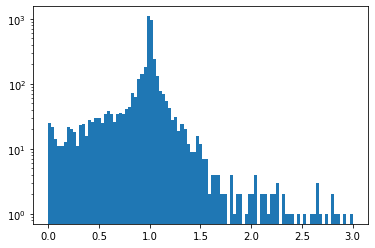

In [14]:
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.yscale("log")

In [18]:
X_0 = data[0]["X"]
ygen_0 = data[0]["ygen"]

X_1 = data[1]["X"]
ygen_1 = data[1]["ygen"]

X_2 = data[2]["X"]
ygen_2 = data[2]["ygen"]

X_3 = data[3]["X"]
ygen_3 = data[3]["ygen"]

X_4 = data[4]["X"]
ygen_4 = data[4]["ygen"]

X_5 = data[5]["X"]
ygen_5 = data[5]["ygen"]

X_6 = data[6]["X"]
ygen_6 = data[6]["ygen"]

X_7 = data[7]["X"]
ygen_7 = data[7]["ygen"]

X_8 = data[8]["X"]
ygen_8 = data[8]["ygen"]

X_9 = data[9]["X"]
ygen_9 = data[9]["ygen"]

# # Concatenate all X arrays
# X = np.concatenate([X_0, X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, X_9], axis=0)

# # Concatenate all ygen arrays
# ygen = np.concatenate([ygen_0, ygen_1, ygen_2, ygen_3, ygen_4, ygen_5, ygen_6, ygen_7, ygen_8, ygen_9], axis=0)



# Find the maximum size along the second dimension
max_size_X = max(X_0.shape[1], X_1.shape[1], X_2.shape[1], X_3.shape[1], X_4.shape[1], X_5.shape[1], X_6.shape[1], X_7.shape[1], X_8.shape[1], X_9.shape[1])

# Pad or truncate X arrays to the maximum size
X_0_padded = np.pad(X_0, ((0, 0), (0, max_size_X - X_0.shape[1]), (0, 0)), mode='constant')
X_1_padded = np.pad(X_1, ((0, 0), (0, max_size_X - X_1.shape[1]), (0, 0)), mode='constant')
X_2_padded = np.pad(X_2, ((0, 0), (0, max_size_X - X_2.shape[1]), (0, 0)), mode='constant')
X_3_padded = np.pad(X_3, ((0, 0), (0, max_size_X - X_3.shape[1]), (0, 0)), mode='constant')
X_4_padded = np.pad(X_4, ((0, 0), (0, max_size_X - X_4.shape[1]), (0, 0)), mode='constant')
X_5_padded = np.pad(X_5, ((0, 0), (0, max_size_X - X_5.shape[1]), (0, 0)), mode='constant')
X_6_padded = np.pad(X_6, ((0, 0), (0, max_size_X - X_6.shape[1]), (0, 0)), mode='constant')
X_7_padded = np.pad(X_7, ((0, 0), (0, max_size_X - X_7.shape[1]), (0, 0)), mode='constant')
X_8_padded = np.pad(X_8, ((0, 0), (0, max_size_X - X_8.shape[1]), (0, 0)), mode='constant')
X_9_padded = np.pad(X_9, ((0, 0), (0, max_size_X - X_9.shape[1]), (0, 0)), mode='constant')

# Concatenate all X arrays
X = np.concatenate([X_0_padded, X_1_padded, X_2_padded, X_3_padded, X_4_padded, X_5_padded, X_6_padded, X_7_padded, X_8_padded, X_9_padded], axis=0)


max_size_ygen = max(ygen_0.shape[1], ygen_1.shape[1], ygen_2.shape[1], ygen_3.shape[1], ygen_4.shape[1], ygen_5.shape[1], ygen_6.shape[1], ygen_7.shape[1], ygen_8.shape[1], ygen_9.shape[1])

# Pad or truncate ygen arrays to the maximum size
ygen_0_padded = np.pad(ygen_0, ((0, 0), (0, max_size_ygen - ygen_0.shape[1]), (0, 0)), mode='constant')
ygen_1_padded = np.pad(ygen_1, ((0, 0), (0, max_size_ygen - ygen_1.shape[1]), (0, 0)), mode='constant')
ygen_2_padded = np.pad(ygen_2, ((0, 0), (0, max_size_ygen - ygen_2.shape[1]), (0, 0)), mode='constant')
ygen_3_padded = np.pad(ygen_3, ((0, 0), (0, max_size_ygen - ygen_3.shape[1]), (0, 0)), mode='constant')
ygen_4_padded = np.pad(ygen_4, ((0, 0), (0, max_size_ygen - ygen_4.shape[1]), (0, 0)), mode='constant')
ygen_5_padded = np.pad(ygen_5, ((0, 0), (0, max_size_ygen - ygen_5.shape[1]), (0, 0)), mode='constant')
ygen_6_padded = np.pad(ygen_6, ((0, 0), (0, max_size_ygen - ygen_6.shape[1]), (0, 0)), mode='constant')
ygen_7_padded = np.pad(ygen_7, ((0, 0), (0, max_size_ygen - ygen_7.shape[1]), (0, 0)), mode='constant')
ygen_8_padded = np.pad(ygen_8, ((0, 0), (0, max_size_ygen - ygen_8.shape[1]), (0, 0)), mode='constant')
ygen_9_padded = np.pad(ygen_9, ((0, 0), (0, max_size_ygen - ygen_9.shape[1]), (0, 0)), mode='constant')

# Concatenate all ygen arrays
ygen_padded = np.concatenate([ygen_0_padded, ygen_1_padded, ygen_2_padded, ygen_3_padded, ygen_4_padded, ygen_5_padded, ygen_6_padded, ygen_7_padded, ygen_8_padded, ygen_9_padded], axis=0)


In [21]:
# Lists to store standardized batches
standardized_Xs_batches = []
standardized_ys_batches = []

# Standardize each batch separately
for ibatch in range(len(Xs)):
    # Calculate mean and standard deviation for the current batch along axis 0
    X_batch = Xs[ibatch]
    ys_batch = ys[ibatch]
    
    X_batch_mean = np.mean(X_batch, axis=0)
    X_batch_std = np.std(X_batch, axis=0)
    
    ys_batch_mean = np.mean(ys_batch, axis=0)
    ys_batch_std = np.std(ys_batch, axis=0)

    # Standardize the batch
    standardized_X_batch = (X_batch - X_batch_mean) / X_batch_std
    standardized_ys_batch = (ys_batch - ys_batch_mean) / ys_batch_std

    # Print shapes for debugging
    print(f"Batch {ibatch}: X shape={standardized_X_batch.shape}, ys shape={standardized_ys_batch.shape}")

    # Append to the lists
    standardized_Xs_batches.append(standardized_X_batch)
    standardized_ys_batches.append(standardized_ys_batch)

# Concatenate standardized batches
standardized_Xs = np.concatenate(standardized_Xs_batches, axis=0)
standardized_ys = np.concatenate(standardized_ys_batches, axis=0)

# Rest of your code...

# Now, you can use standardized_Xs and stand


Batch 0: X shape=(10, 111, 17), ys shape=(10, 111, 8)
Batch 1: X shape=(10, 186, 17), ys shape=(10, 186, 8)
Batch 2: X shape=(10, 142, 17), ys shape=(10, 142, 8)
Batch 3: X shape=(10, 90, 17), ys shape=(10, 90, 8)
Batch 4: X shape=(10, 111, 17), ys shape=(10, 111, 8)
Batch 5: X shape=(10, 195, 17), ys shape=(10, 195, 8)
Batch 6: X shape=(10, 100, 17), ys shape=(10, 100, 8)
Batch 7: X shape=(10, 81, 17), ys shape=(10, 81, 8)
Batch 8: X shape=(10, 130, 17), ys shape=(10, 130, 8)
Batch 9: X shape=(10, 147, 17), ys shape=(10, 147, 8)


/tmp/sraj/ipykernel_4078517/1706304707.py:18: RuntimeWarning: invalid value encountered in divide
  standardized_X_batch = (X_batch - X_batch_mean) / X_batch_std
/tmp/sraj/ipykernel_4078517/1706304707.py:19: RuntimeWarning: invalid value encountered in divide
  standardized_ys_batch = (ys_batch - ys_batch_mean) / ys_batch_std


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 111 and the array at index 1 has size 186

In [28]:
# Standardize each batch separately with zero-padding
max_len_x = max(X.shape[1] for X in Xs)
max_len_y = max(y.shape[1] for y in ys)

standardized_Xs_batches = [np.pad(X, ((0, 0), (0, max_len_x - X.shape[1]), (0, 0)), 'constant') for X in Xs]
standardized_ys_batches = [np.pad(y, ((0, 0), (0, max_len_y - y.shape[1]), (0, 0)), 'constant') for y in ys]

# Concatenate padded batches
standardized_Xs = np.concatenate(standardized_Xs_batches, axis=0)
standardized_ys = np.concatenate(standardized_ys_batches, axis=0)


In [29]:
# Quantize the datasets to int8
quantized_Xs = np.round(standardized_Xs * 127).astype(np.int8)
quantized_ys = np.round(standardized_ys * 127).astype(np.int8)


In [32]:
# Create a representative dataset function
def representative_dataset_gen():
    for i in range(10):  # Adjust the number of samples as needed
        resized_input = np.zeros((1, 195, 17), dtype=np.float32)  # Assuming 195 is the desired size
        resized_input[:, :quantized_Xs[i].shape[1], :] = quantized_Xs[i].astype(np.float32)
        yield [resized_input]

In [33]:
# Quantize the model with a representative dataset
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_dataset_gen

quantized_model = converter.convert()

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


ValueError: could not broadcast input array from shape (195,17) into shape (1,17,17)

2023-11-30 16:51:15.592425: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-30 16:51:15.592740: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-30 16:51:15.593037: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmp3eqj_it1
2023-11-30 16:51:15.653953: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-30 16:51:15.653998: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmp3eqj_it1
2023-11-30 16:51:15.914981: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-11-30 16:51:16.783375: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmp3eqj_it1
2023-11-30 16:51:17.311090: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: O

In [38]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

# Convert the new model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("quantized_model.tflite", "wb") as f:
    f.write(quantized_tflite_model)


2023-11-30 16:55:52.710952: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-30 16:55:52.711253: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-30 16:55:52.711549: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmpimjp0ke4
2023-11-30 16:55:52.771507: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-30 16:55:52.771562: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmpimjp0ke4
2023-11-30 16:55:53.012667: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-11-30 16:55:53.866462: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmpimjp0ke4
2023-11-30 16:55:54.405873: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: O

In [41]:
# Load the Quantized TensorFlow Lite Model:
# Load the quantized TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="quantized_model.tflite")
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
# Prepare Input Data:
